<a href="https://colab.research.google.com/github/taasinsaquib/retina/blob/main/onv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/thesis_stuff/'

/content/drive/MyDrive/thesis_stuff


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import time
import copy
import sys

In [4]:
! pip install livelossplot torchinfo --quiet
# ! pip install pytorch-spiking

In [5]:
import torch
import torch.nn as nn
from   torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision
from   torchvision import transforms, utils
from   torchinfo   import summary

# import pytorch_spiking

# specific package for visualization
from livelossplot import PlotLosses

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
seed = 28

np.random.seed(seed)

# ONV has 14400 photoreceptors, reshape to a square for RESNET
w = 120
h = 120

In [ ]:
# Experiment with global average pooling

"""
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((1,1))
input = torch.randn(1, 2, 3, 3)
print(input)
output = m(input)
print(output)
print(output.shape)

# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)

# target output size of 10x7
m = nn.AdaptiveAvgPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)
"""

# Data

In [69]:
class ONVData(Dataset):

    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):

        x, y = self.subset[index]

        # ResNET 2 channels
        # make square 120x120
        """
        x = np.resize(x, (w, h))

        posIdx = np.where(x == 1)
        negIdx = np.where(x == -1)

        channel1 = channel2 = np.zeros((w, h))
        newData = np.zeros((2, w, h), dtype=np.float)

        newData[0][posIdx] = 1
        newData[1][negIdx] = -1
        
        # print(type(x))
        x = torch.from_numpy(newData)
        # print(type(x))
        """

        # Spiking add timesteps
        """
        print(x.shape)
        x = np.tile(x[None, :], (n_steps, 1))
        print(x.shape)
        x = torch.from_numpy(x)
        """

        if self.transform:
          x = self.transform(x)

        return x, y

## Combine

### Helpers

In [13]:
def combineDataRadii(dir, radii):
  # insert some zero data (TODO: more than 1 row?)

  z = np.zeros((14400))
  data_train = data_test = z

  z = np.zeros((3))
  labels_train = labels_test = z
  centers_train = centers_test = z

  for r in radii:
    r = np.around(r, decimals=1)

    d = np.load(f'./{dir}/data_circle_away_{r}.npy')
    l = np.load(f'./{dir}/labels_circle_away_{r}.npy')
    c = np.load(f'./{dir}/centers_circle_away_{r}.npy')

    n = len(d)
    nTrain = int(n * 0.8)
    nTest  = n - nTrain

    idx = np.random.RandomState(seed=int(r*100)).permutation(n)
    trainIdx = idx[ :nTrain]
    testIdx  = idx[nTrain+1: ]

    data_train = np.vstack((data_train, d[trainIdx]))
    data_test  = np.vstack((data_test, d[testIdx]))

    labels_train = np.vstack((labels_train, l[trainIdx]))
    labels_test  = np.vstack((labels_test, l[testIdx]))

    centers_train = np.vstack((centers_train, c[trainIdx]))
    centers_test  = np.vstack((centers_test, c[testIdx]))

  print(data_train.shape,    data_test.shape)
  print(labels_train.shape,  labels_test.shape)
  print(centers_train.shape, centers_test.shape)

  np.save(f'./{dir}/data_train', data_train)
  np.save(f'./{dir}/data_test',  data_test)

  np.save(f'./{dir}/labels_train', labels_train)
  np.save(f'./{dir}/labels_test',  labels_test)

  np.save(f'./{dir}/centers_train', centers_train)
  np.save(f'./{dir}/centers_test',  centers_test)

In [14]:
def combineDataLR(sizes, types):
  data   = None
  labels = None

  for s in sizes:
    for t in types:

      d = np.load(f'./retina_LR/data_dist_{s}_{t}.npy')
      l = np.load(f'./retina_LR/labels_dist_{s}_{t}.npy')

      if data is None:
        data   = d
        labels = l
    
      else:
        data   = np.vstack((data, d))
        labels = np.vstack((labels, l))

  return data, labels

### LR

In [15]:
sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
types = ['L', 'R']

data, labels = combineDataLR(sizes, types)

KeyboardInterrupt: ignored

In [ ]:
shuffler = np.random.RandomState(seed=seed).permutation(len(labels))

data_shuffled   = data[shuffler]
labels_shuffled = labels[shuffler]

np.save('./retina_LR/data_combined',   data_shuffled)
np.save('./retina_LR/labels_combined', labels_shuffled)

### Angles

In [ ]:
# Data with only away, not towards
radii = np.arange(0.2, 2.0, 0.1)
combineDataRadii('sphere_away', radii)

## Load

### LR

In [ ]:
data   = np.load('./retina_LR/data_combined.npy')
labels = np.load('./retina_LR/labels_combined.npy')
print(data.shape, labels.shape)

(4080, 14400) (4080, 3)


In [ ]:
X_data_tensor = torch.from_numpy(data).float()
y_data_tensor = torch.from_numpy(labels).float()
init_dataset = TensorDataset(X_data_tensor, y_data_tensor)

In [ ]:
# split train, val, test
lengths = np.array([0.7, 0.1, 0.2])
lengths *= int(len(init_dataset))
lengths = np.rint(lengths)
lengths = np.asarray(lengths, dtype=np.int32)

# lengths[1] += 1

In [ ]:
print(lengths, np.sum(lengths), len(init_dataset))

[2856  408  816] 4080 4080


In [ ]:
subset_train, subset_val, subset_test = random_split(init_dataset, lengths, generator=torch.Generator().manual_seed(seed)) 

train_data = ONVData(
    subset_train, transform=None)

val_data = ONVData(
    subset_val, transform=None)

test_data = ONVData(
    subset_test, transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,  num_workers=1),
    'val':   torch.utils.data.DataLoader(val_data,   batch_size=8,  shuffle=False, num_workers=1),
    'test':  torch.utils.data.DataLoader(test_data,  batch_size=8,  shuffle=False, num_workers=1),
}

### Angles

In [16]:
def loadData(dir):
  data_train = np.load(f'./{dir}/data_train.npy')
  data_test  = np.load(f'./{dir}/data_test.npy')

  # TODO: turn into degrees or keep radians?
  labels_train = np.load(f'./{dir}/labels_train.npy') * 180/np.pi
  labels_test  = np.load(f'./{dir}/labels_test.npy')  * 180/np.pi

  print(data_train.shape, labels_train.shape    )
  print(data_test.shape,  labels_test.shape)

  return data_train, labels_train, data_test, labels_test

In [17]:
# data_train, labels_train, data_test, labels_test = loadData('center')

In [18]:
data_train, labels_train, data_test, labels_test = loadData('sphere_away')

# X, Y experiment
# labels_train = labels_train[:, :2]
# labels_test = labels_test[:, :2]

(6067, 14400) (6067, 3)
(1513, 14400) (1513, 3)


In [19]:
X_train_tensor = torch.from_numpy(data_train).float()
y_train_tensor = torch.from_numpy(labels_train).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_test_tensor = torch.from_numpy(data_test).float()
y_test_tensor = torch.from_numpy(labels_test).float()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [20]:
# split train, val, test
lengths = np.array([0.65, 0.35, 0])
lengths *= int(len(train_dataset))
lengths = np.rint(lengths)
lengths = np.asarray(lengths, dtype=np.int32)

In [21]:
subset_train, subset_val, _ = random_split(train_dataset, lengths, generator=torch.Generator().manual_seed(seed)) 

train_data = ONVData(
    subset_train, transform=None)

val_data = ONVData(
    subset_val, transform=None)

NameError: ignored

In [ ]:
subset_test = test_dataset

test_data = ONVData(
    subset_test, transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True,  num_workers=1),
    'val':   torch.utils.data.DataLoader(val_data,   batch_size=8,  shuffle=False, num_workers=1),
    'test':  torch.utils.data.DataLoader(test_data,  batch_size=8,  shuffle=False, num_workers=1),
}

## Visualize

In [42]:
# plot ray hits and misses, or hit distances
def visualizeHits(rays, binaryHits):

    title = ''

    # set default background color for rays that didn't intersect w/ geometry
    color = ['dimgrey'] * len(binaryHits)

    title = 'Events'

    for i, s in enumerate(binaryHits):
        if s == -1:
            # color[i] = 0.5
            color[i] = 'dodgerblue'
        elif s == 1:
            # color[i] = 1
            color[i] = 'coral'

    plt.title(title)
    plt.scatter(rays[:, 0:1], rays[:, 1:2], marker='.', c=color)
    plt.xlim([-0.35, 0.35])
    plt.ylim([-0.35, 0.35])
    plt.show()

In [39]:
retina = np.load('./retina_dist.npy')

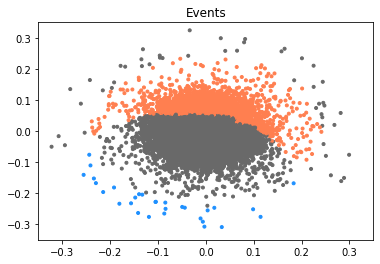

[12.0321137  44.22922455  0.        ]


In [60]:
i = 
visualizeHits(retina[:14400], data_train[i])
print(labels_train[i])

# Training Helpers

In [17]:
def train_model(model, optimizer, num_epochs, atol=1):
    # for each epoch... 
    liveloss = PlotLosses()

    best_model = None
    highest_val = 0

    for epoch in range(num_epochs):
      print('Training Model: ', model.__class__.__name__)
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:

          inputs = inputs.float()
          labels = labels.float()

          inputs = inputs.to(device)
          labels = labels.to(device)

          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
            #    the above line says to disable gradient tracking for validation
            #    which makes sense since the model is in evluation mode and we 
            #    don't want to track gradients for validation)  
            outputs = model(inputs)

            # print("1", outputs.type())
            # print("2", labels.type())

            # compute loss where the loss function will be defined later
            loss = loss_fn(outputs, labels)

            # print("3", loss.type())

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

            train_loss += loss

            c, t = numVectorsMatch(outputs, labels, 0, atol)

            correct += c
            total   += t

            print(correct, total)

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        prefix = ''
        if phase == 'val':
            prefix = 'val_'
            # tune.track.log(mean_accuracy=correct/total)

            if (correct/total) > highest_val:
              print('Best val till now: ', (correct/total))
              highest_val = (correct/total)
              # logs['what'] = highest_val
              best_model = copy.deepcopy(model)

        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = (correct / total) * 100

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return best_model, model

In [18]:
def test_model(model, atol):

  total = correct = 0

  for inputs, labels in dataloaders['test']:

    inputs = inputs.float()
    labels = labels.float()

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    # print(outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())

    c, t = numVectorsMatch(outputs, labels, 0, atol)
    correct += c
    total   += t

  return (correct/total) * 100

In [19]:
def numVectorsMatch(outputs, labels, rtol = 0, atol = 0.5):

  correct = 0
  total   = labels.size(0)

  # print("0")

  # rounding with torch
  # n_digits = 2
  # https://discuss.pytorch.org/t/round-tensor-to-x-decimal-places/25832
  # labels = torch.round(labels * 10**n_digits) / (10**n_digits)
  # outputs = torch.round(outputs * 10**n_digits) / (10**n_digits)

  # print("1")
  close = torch.isclose(outputs, labels, rtol, atol)
  # print("2", close.size)

  for r in close:
    if torch.sum(r == True) == 3:
      correct += 1
  # print("3")
  # for i in range(0, len(outputs)):
    # if torch.allclose(outputs[i], labels[i], rtol, atol):
      # correct += 1
      # print(outputs[i], labels[i])

  return correct, total

In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
def pipeline(model, lr=1e-2, weight_decay=0.1, epochs=25):
  
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # TODO: tune betas
  
  best_model, m = train_model(model, opt, num_epochs=epochs, atol=5)

  return best_model, m

# Models

## ANNs

In [22]:
class ANN1(nn.Module):
  def __init__(self):
    super(ANN1, self).__init__()

    self.fc1 = nn.Linear(14400, 5000)
    self.fc4 = nn.Linear(5000, 1000)
    self.fc2 = nn.Linear(1000, 100)
    self.fc3 = nn.Linear(100, 3)

  def forward(self, x):

    # x = x.view(-1, w*h)

    print(x.shape)

    x = self.fc1(x)
    x = torch.relu(x)

    x = self.fc4(x)
    x = torch.relu(x)

    x = self.fc2(x)
    x = torch.relu(x)

    x = self.fc3(x)

    return x

# ResNet Experiments

## Model

In [ ]:
class MyResNet(nn.Module):
  def __init__(self, pretrained):
    super(MyResNet, self).__init__()
    
    self.pretrained = pretrained
    # self.input = nn.Conv2d(2, 3, (2, 4280), stride=1, padding='same')
    self.input = nn.Conv2d(2, 3, (3, 3), stride=1, padding='same')

    self.fc1 = nn.Linear(256, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self, x):

    # print(x.shape)

    x = self.input(x)

    # print(x.shape)

    x = self.pretrained(x)

    # print((x).type())

    x = self.fc1(x)
    x = torch.relu(x)

    x = self.fc2(x)

    return x

In [ ]:
modResnet = torchvision.models.resnet18(pretrained=True)

for param in modResnet.parameters():
    param.requires_grad = True

modResnet.fc = nn.Linear(512, 256)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
summary(modResnet, input_size=(32, 3, w, h))

## Exp \#1
* got _v2 to 78% accuracy
  * trained around 75-100 epochs, dropping and raising learning rate between 1e-2 and 1e-4
  * TODO: explore other hyperparams
  * TODO: need to make vector comparison margin tighter, like 0.1
* inference works sometimes, better when in middle of retina
  * polarity sometimes switches
* can't generalize well to odd movement since data is all even
  * TODO: collect more of this
* TODO: try delta gaze?
  * x, y, z rotation as labels O.O


In [ ]:
model = MyResNet(modResnet)
model.float()
model.to(device)

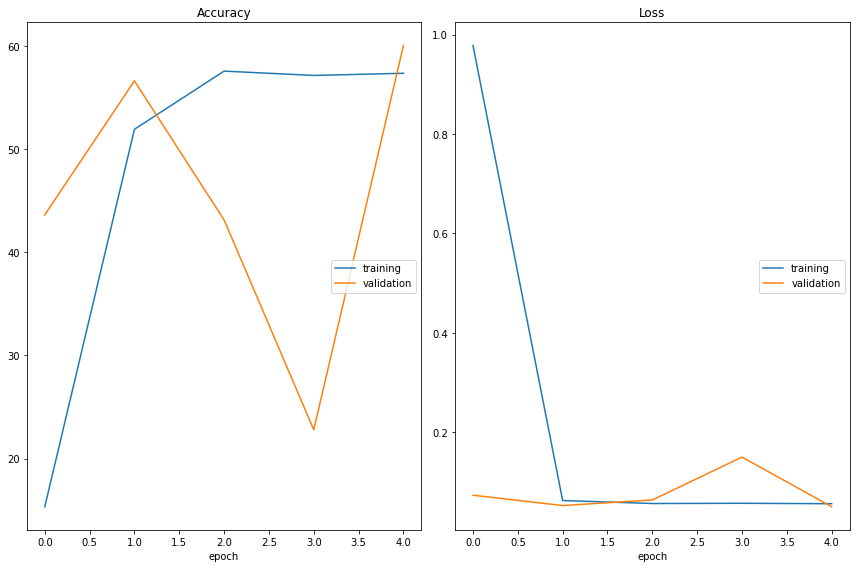

Accuracy
	training         	 (min:   15.336, max:   57.563, cur:   57.353)
	validation       	 (min:   22.794, max:   60.049, cur:   60.049)
Loss
	training         	 (min:    0.057, max:    0.978, cur:    0.057)
	validation       	 (min:    0.050, max:    0.150, cur:    0.050)


In [ ]:
best, last = pipeline(model, epochs=5)

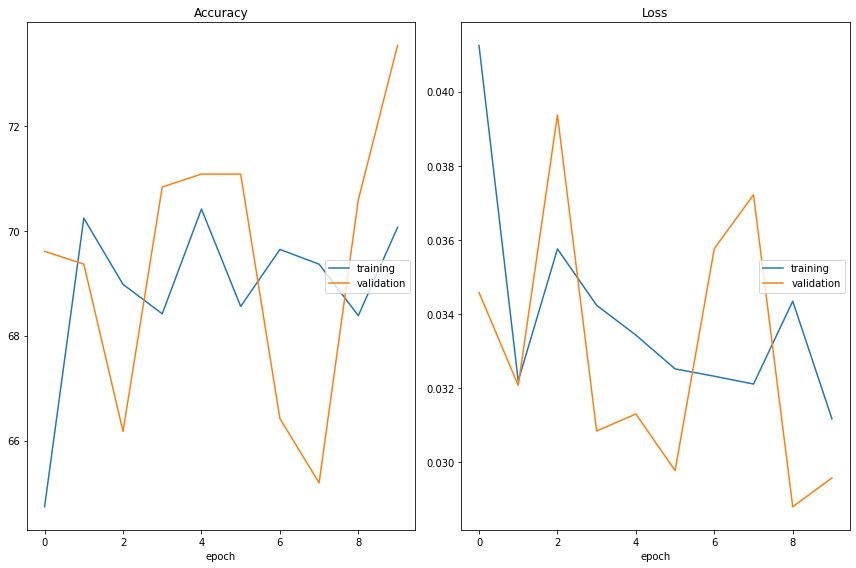

Accuracy
	training         	 (min:   64.741, max:   70.413, cur:   70.063)
	validation       	 (min:   65.196, max:   73.529, cur:   73.529)
Loss
	training         	 (min:    0.031, max:    0.041, cur:    0.031)
	validation       	 (min:    0.029, max:    0.039, cur:    0.030)


In [ ]:
best, last = pipeline(best, epochs=10, lr=1e-3)

In [ ]:
best.eval()
acc = test_model(best)
print(acc)

71.56862745098039


In [ ]:
 torch.save(best, 'onv_resnet_v2')
 torch.save(best.state_dict(), 'onv_resnet_v2_dict')

In [ ]:
m = torch.load('./onv_resnet_v2')

## Exp \#2
* epochs, 5 (1e-2), 25
* 50 (1e-2), 50 (1e-3) already reached 50% accuracy at the end of the first 50
  * limit at 50% because half of the data is the exact opposite of the other half (multiplied by -1). So it looks like the network can't combine both representations

In [ ]:
model = MyResNet(modResnet)
model.float()
model.to(device)

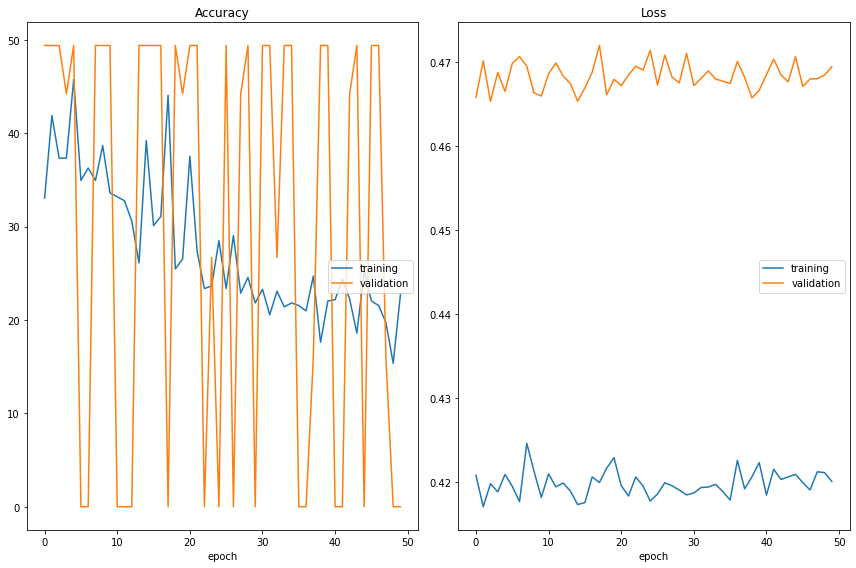

Accuracy
	training         	 (min:   15.368, max:   45.754, cur:   22.737)
	validation       	 (min:    0.000, max:   49.402, cur:    0.000)
Loss
	training         	 (min:    0.417, max:    0.425, cur:    0.420)
	validation       	 (min:    0.465, max:    0.472, cur:    0.469)


In [ ]:
best, last = pipeline(best, epochs=50, lr=1e-3)

In [ ]:
model = ANN1()
model.float()
model.to(device)

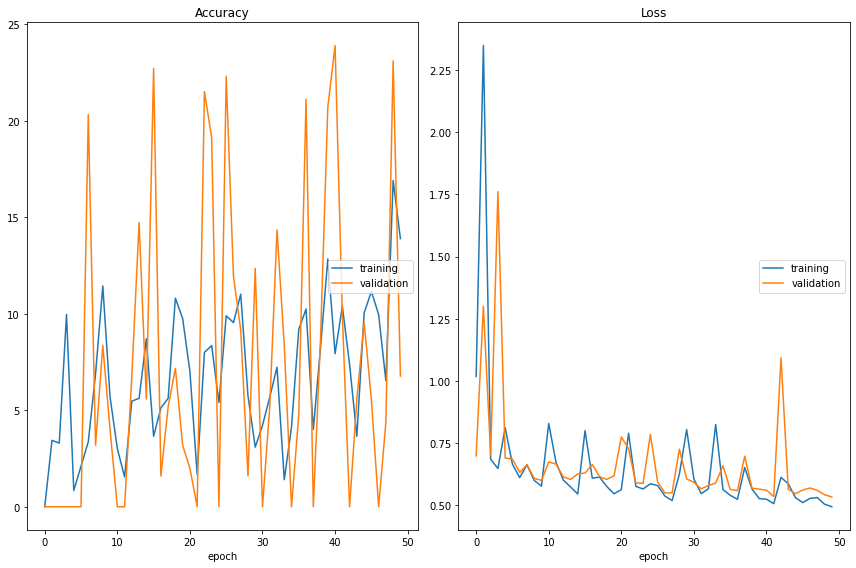

Accuracy
	training         	 (min:    0.000, max:   16.912, cur:   13.895)
	validation       	 (min:    0.000, max:   23.904, cur:    6.773)
Loss
	training         	 (min:    0.494, max:    2.349, cur:    0.494)
	validation       	 (min:    0.533, max:    1.761, cur:    0.533)


In [ ]:
best, last = pipeline(model, epochs=50, lr=1e-3)

# FC

In [22]:
class FC1(nn.Module):
  def __init__(self):
    super(FC1, self).__init__()

    self.fc1 = nn.Linear(14400, 10000)
    self.fc2 = nn.Linear(10000, 1000)
    self.fc3 = nn.Linear(1000, 100)
    self.fc4 = nn.Linear(100, 10)
    self.fc5 = nn.Linear(10, 3)

    self.drop1 = nn.Dropout(p=0.1)
    self.drop2 = nn.Dropout(p=0.1)
    self.drop3 = nn.Dropout(p=0.15)
    self.drop4 = nn.Dropout(p=0.15)

  def forward(self, x):

    # x = x.view(-1, w*h)

    # print(x.shape)

    x = self.fc1(x)
    x = torch.relu(x)
    x = self.drop1(x)

    x = self.fc2(x)
    x = torch.relu(x)
    x = self.drop2(x)

    x = self.fc3(x)
    x = torch.relu(x)
    x = self.drop3(x)

    x = self.fc4(x)
    x = torch.relu(x)
    x = self.drop4(x)

    x = self.fc5(x)

    return x

In [23]:
model = FC1()
# model = torch.load('./fc_away_v1')

In [24]:
model.float()
model.to(device)

FC1(
  (fc1): Linear(in_features=14400, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=3, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.1, inplace=False)
  (drop3): Dropout(p=0.1, inplace=False)
  (drop4): Dropout(p=0.1, inplace=False)
)

## Exp 1
* overfit?

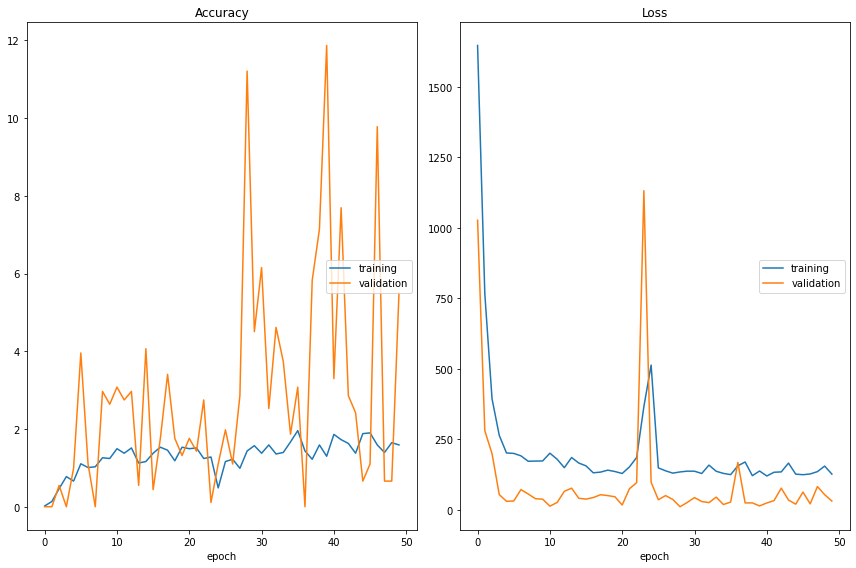

Accuracy
	training         	 (min:    0.019, max:    1.959, cur:    1.590)
	validation       	 (min:    0.000, max:   11.868, cur:    5.495)
Loss
	training         	 (min:  119.784, max: 1647.244, cur:  126.439)
	validation       	 (min:   10.714, max: 1131.869, cur:   30.937)


In [24]:
best, last = pipeline(model, epochs=50, lr=1e-3, weight_decay=1e-2)

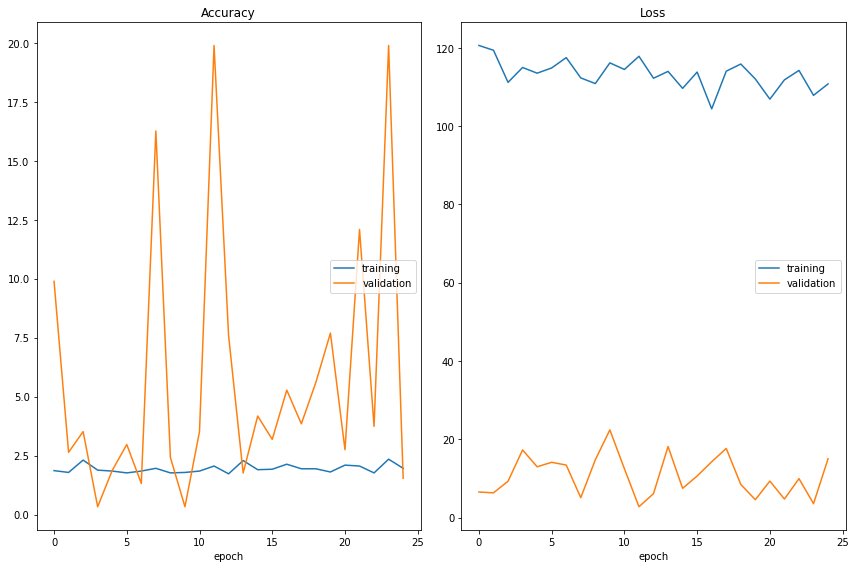

Accuracy
	training         	 (min:    1.726, max:    2.346, cur:    1.959)
	validation       	 (min:    0.330, max:   19.890, cur:    1.538)
Loss
	training         	 (min:  104.416, max:  120.619, cur:  110.798)
	validation       	 (min:    2.751, max:   22.385, cur:   15.013)


In [25]:
best, last = pipeline(best, epochs=25, lr=1e-4, weight_decay=1e-2)

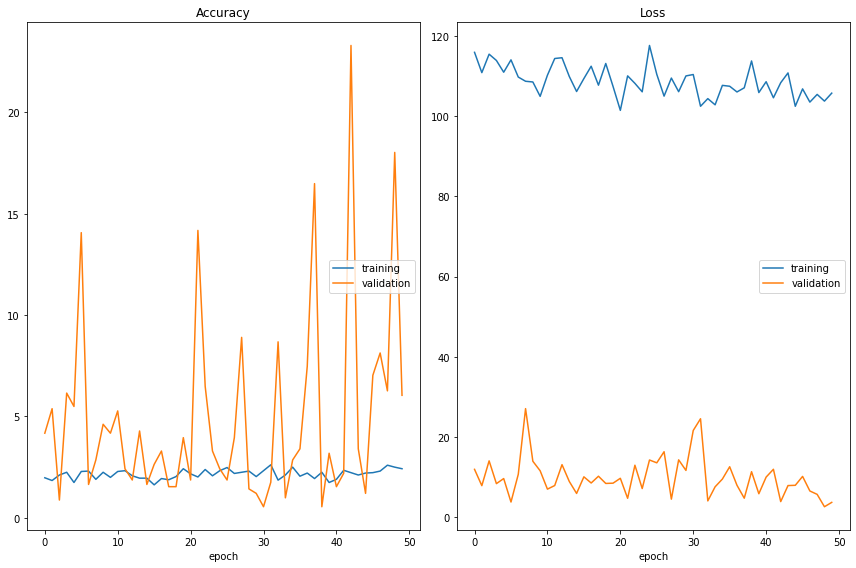

Accuracy
	training         	 (min:    1.629, max:    2.618, cur:    2.424)
	validation       	 (min:    0.549, max:   23.297, cur:    6.044)
Loss
	training         	 (min:  101.450, max:  117.632, cur:  105.743)
	validation       	 (min:    2.616, max:   27.080, cur:    3.704)


In [24]:
best, last = pipeline(model, epochs=50, lr=1e-4, weight_decay=1e-2)

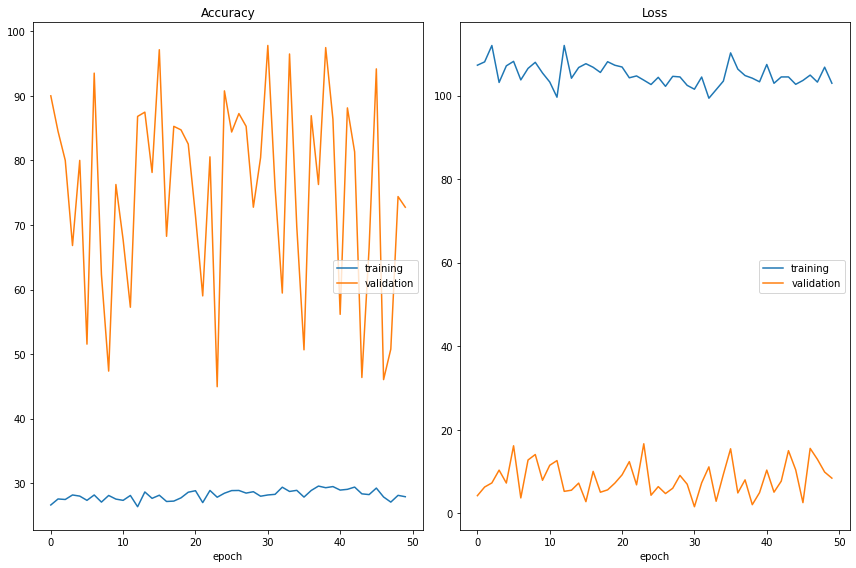

Accuracy
	training         	 (min:   26.353, max:   29.552, cur:   27.904)
	validation       	 (min:   44.945, max:   97.802, cur:   72.747)
Loss
	training         	 (min:   99.353, max:  111.979, cur:  102.940)
	validation       	 (min:    1.593, max:   16.664, cur:    8.432)


In [26]:
best, last = pipeline(model, epochs=50, lr=1e-4, weight_decay=1e-2)

In [27]:
best.eval()
acc = test_model(best, 5)
print(acc)

97.48843357567746


In [28]:
torch.save(best, 'fc_away_v1')
torch.save(best.state_dict(), 'fc_away_v1_dict')

## Exp 2

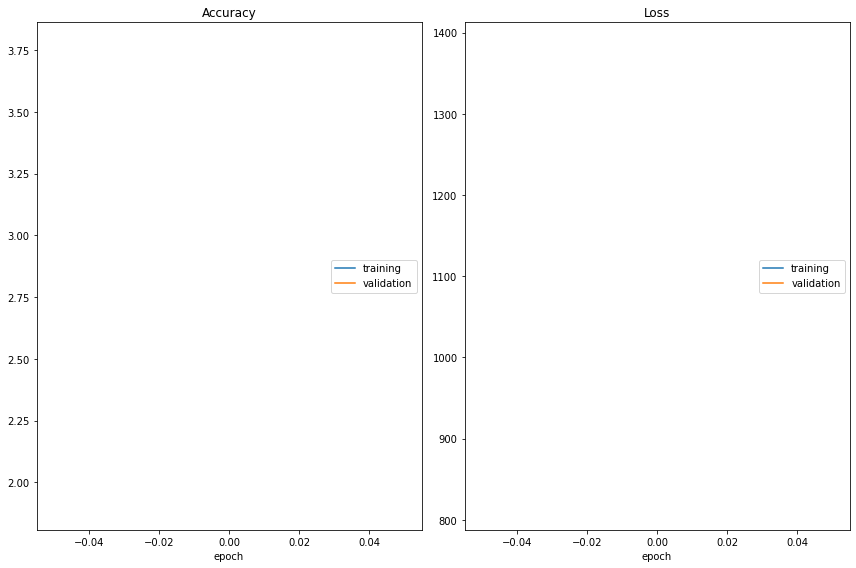

Accuracy
	training         	 (min:    1.902, max:    1.902, cur:    1.902)
	validation       	 (min:    3.768, max:    3.768, cur:    3.768)
Loss
	training         	 (min: 1384.112, max: 1384.112, cur: 1384.112)
	validation       	 (min:  816.155, max:  816.155, cur:  816.155)
Training Model:  FC1
Epoch 1/49
----------
LR 0.001


RuntimeError: ignored

In [83]:
best, last = pipeline(best, epochs=50, lr=1e-3, weight_decay=1e-1)

In [81]:
model.eval()
acc = test_model(model, 5)
print(acc)

2.9081295439524126


# TODO
  * only use X, Y labels
  * LiNet
  * EOC muscle controller

# PyTorch Spiking

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/thesis_stuff/'

/content/drive/MyDrive/thesis_stuff


In [ ]:
! pip install livelossplot torchinfo --quiet
! pip install pytorch-spiking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from   torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision
from   torchvision import transforms, utils
from   torchinfo   import summary

import pytorch_spiking

import time
import copy
import sys

# specific package for visualization
from livelossplot import PlotLosses

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
seed = 28
np.random.seed(seed)

# ONV has 14400 photoreceptors, reshape to a square for RESNET
w = 120
h = 120

# for SNN
n_steps = 5

## Data

In [ ]:
data_train = np.load('./center/data_train.npy')
data_test  = np.load('./center/data_test.npy')

labels_train = np.load('./center/labels_train.npy') * 180/np.pi
labels_test  = np.load('./center/labels_test.npy')  * 180/np.pi

# labels_train = np.load('./center/centers_train.npy')
# labels_test  = np.load('./center/centers_test.npy')

print(data_train.shape, labels_train.shape)
print(data_test.shape, labels_test.shape)

(1676, 14400) (1676, 3)
(409, 14400) (409, 3)


In [ ]:
# repeat the images for n_steps
# TODO: do this in ONVData to save memory (if needed)

# data_train = np.tile(data_train[:, None], (1, n_steps, 1))
# data_test  = np.tile(data_test[:, None], (1, n_steps, 1))

# print(data_train.shape)
# print(data_test.shape)

In [ ]:
X_train_tensor = torch.from_numpy(data_train).float()
y_train_tensor = torch.from_numpy(labels_train).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_test_tensor = torch.from_numpy(data_test).float()
y_test_tensor = torch.from_numpy(labels_test).float()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
# split train, val, test
lengths = np.array([0.85, 0.15, 0])
lengths *= int(len(train_dataset))
lengths = np.rint(lengths)
lengths = np.asarray(lengths, dtype=np.int32)

In [ ]:
subset_train, subset_val, _ = random_split(train_dataset, lengths, generator=torch.Generator().manual_seed(seed)) 

train_data = ONVData(
    subset_train, transform=None)

val_data = ONVData(
    subset_val, transform=None)

In [ ]:
subset_test = test_dataset

test_data = ONVData(
    subset_test, transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True,  num_workers=1),
    'val':   torch.utils.data.DataLoader(val_data,   batch_size=8,  shuffle=False, num_workers=1),
    'test':  torch.utils.data.DataLoader(test_data,  batch_size=8,  shuffle=False, num_workers=1),
}

## Model

In [ ]:
class ANNSpiking(nn.Module):
  def __init__(self):
    super(ANNSpiking, self).__init__()

    self.fc1 = nn.Linear(14400, 5000)
    self.fc2 = nn.Linear(5000, 1000)
    self.fc3 = nn.Linear(1000, 3)

    self.pool = pytorch_spiking.TemporalAvgPool()

    self.spike1 = pytorch_spiking.SpikingActivation(nn.ReLU(), spiking_aware_training=True)
    self.spike2 = pytorch_spiking.SpikingActivation(nn.ReLU(), spiking_aware_training=True)
  
    # self.spike1 = nn.ReLU()
    # self.spike2 = nn.ReLU()

  def forward(self, x):

    # x = x.view(-1, w*h)

    # print(x.shape)

    x = self.fc1(x)

    x = x.cpu()
    x = self.spike1(x)
    x = x.cuda()

    x = self.fc2(x)

    x = x.cpu()
    x = self.spike2(x)
    x = x.cuda()
    
    x = self.pool(x)

    x = self.fc3(x)

    return x

## Train

In [ ]:
model = ANNSpiking()
model.float()
model.to(device)

ANNSpiking(
  (fc1): Linear(in_features=14400, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=3, bias=True)
  (pool): TemporalAvgPool()
  (spike1): SpikingActivation(
    (activation): ReLU()
  )
  (spike2): SpikingActivation(
    (activation): ReLU()
  )
)

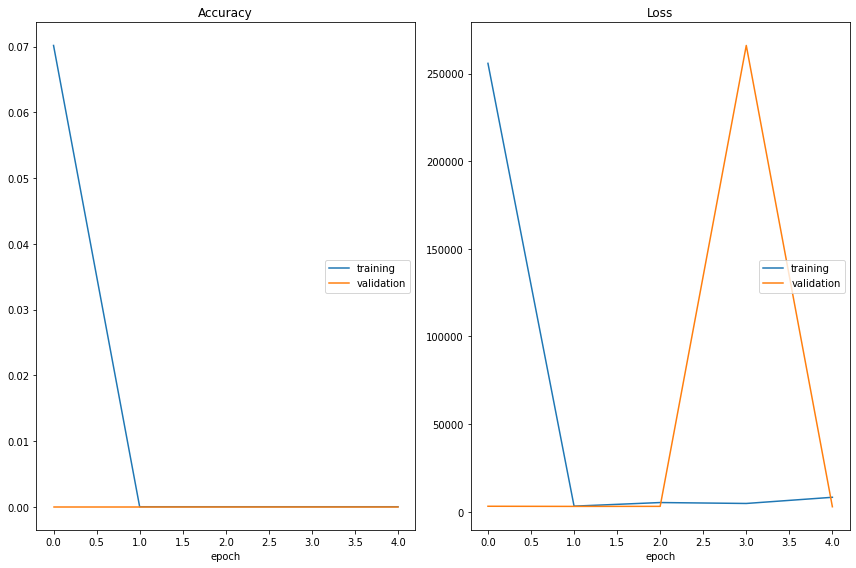

Accuracy
	training         	 (min:    0.000, max:    0.070, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min: 3184.422, max: 255846.311, cur: 8238.522)
	validation       	 (min: 2847.015, max: 266049.250, cur: 2847.015)


In [ ]:
best, last = pipeline(model, epochs=5, lr=1e-2)

In [ ]:
# TODO: analysis of spikes like in tutorial

# Nengo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/thesis_stuff/'

[Errno 2] No such file or directory: 'drive/MyDrive/thesis_stuff/'
/content/drive/MyDrive/thesis_stuff


## Setup

In [ ]:
! pip install nengo nengo_dl tensorflow-gpu --quiet

     |████████████████████████████████| 523 kB 7.3 MB/s 
     |████████████████████████████████| 283 kB 63.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 454.4 MB 10.0 kB/s 


In [ ]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nengo
import nengo_dl
from nengo.utils.matplotlib import rasterplot

import warnings
import datetime, os

warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

In [ ]:
seed = 28
batchSize = 32

nInputs  = 1000
inputDim = 14400
w = h = 120

nSteps = 10

In [ ]:
# choose first GPU if available
physicalDevices = tf.config.list_physical_devices('GPU')
print(physicalDevices)
device = "/gpu:0" if len(physicalDevices) > 0 else "/cpu:0"
print(device)

device = '/gpu:0'

[]
/cpu:0


## Data
* add time dimension

In [ ]:
data_train = np.load('./center/data_train.npy')
data_test  = np.load('./center/data_test.npy')

labels_train = np.load('./center/labels_train.npy') * 180/np.pi
labels_test  = np.load('./center/labels_test.npy')  * 180/np.pi

# labels_train = np.load('./center/centers_train.npy')
# labels_test  = np.load('./center/centers_test.npy')

# labels_train[np.abs(labels_train) < 1e-3] = 0
# labels_test[np.abs(labels_test) < 1e-3]   = 0

print(data_train.shape, labels_train.shape)
print(data_test.shape, labels_test.shape)

(1676, 14400) (1676, 3)
(409, 14400) (409, 3)


In [ ]:
# data_train = np.resize(data_train, (1676, w, h))
# data_test  = np.resize(data_test, (409, w, h))

# print(data_train.shape, labels_train.shape)
# print(data_test.shape, labels_test.shape)

(1676, 120, 120) (1676, 3)
(409, 120, 120) (409, 3)


In [ ]:
data_train = data_train[:, None, :]
labels_train = labels_train[:, None, :]
print(data_train.shape, labels_train.shape)

(1676, 1, 14400) (1676, 1, 3)


In [ ]:
data_test = data_test[:, None, :]
labels_test = labels_test[:, None, :]
print(data_test.shape, labels_test.shape)

(409, 1, 14400) (409, 1, 3)


## Network

In [ ]:
class MyFCNet(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(MyFCNet, self).__init__(name='')

    self.fc1 = tf.keras.layers.Dense(3)

In [ ]:
with nengo.Network(seed=seed) as net:
  # nengo_dl.configure_settings(lif_smoothing=x)
  # nengo_dl.configure_settings(inference_only=True)  # for testing
  neuron_type = nengo.LIF(amplitude=0.01)

  input = nengo.Node(np.zeros(inputDim))

  # first dense
  x = nengo_dl.Layer(tf.keras.layers.Dense(10000))(input)
  x = nengo_dl.Layer(neuron_type)(x)

  # first dense
  x = nengo_dl.Layer(tf.keras.layers.Dense(1000))(input)
  x = nengo_dl.Layer(neuron_type)(x)

  # second dense
  x = nengo_dl.Layer(tf.keras.layers.Dense(100))(x)
  x = nengo_dl.Layer(neuron_type)(x)

  # output
  out = nengo_dl.Layer(tf.keras.layers.Dense(3))(x)

  out_p = nengo.Probe(out, label="out_p")

  """
  # we'll create one ensemble with rate neurons
  ensemble1 = nengo.Ensemble(1000, 14400, neuron_type=neuron_type, seed=seed)
  nengo.Connection(input, ensemble1)

  # and another ensemble with spiking neurons
  ensemble2 = nengo.Ensemble(100, 14400, neuron_type=neuron_type, seed=seed)
  nengo.Connection(ensemble1, ensemble2)

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=1000, activation='relu'))(ensemble2)

  out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(x)

  output = nengo.Probe(out)
  """


In [ ]:
with nengo.Network(seed=seed) as net:
  neuron_type = nengo.LIF(amplitude=0.01)

  input = nengo.Node(np.zeros(inputDim))

  # add the first convolutional layer  
  x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=5))(
      input, shape_in=(w, h, 1)
  )

  # apply the neural nonlinearity
  x = nengo_dl.Layer(neuron_type)(x)

  # add another convolutional layer
  x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, kernel_size=5))(
      x, shape_in=(w-4, h-4, 32)
  )
  x = nengo_dl.Layer(neuron_type)(x)

  # add a pooling layer
  x = nengo_dl.Layer(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))(
      x, shape_in=(w-8, h-8, 64)
  )

  # linear readout

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=1000))(x)
  x = nengo_dl.Layer(neuron_type)(x)

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=100))(x)
  x = nengo_dl.Layer(neuron_type)(x)
  
  out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(x)

  # we'll create two different output probes, one with a filter
  # (for when we're simulating the network over time and
  # accumulating spikes), and one without (for when we're
  # training the network using a rate-based approximation)
  out_p = nengo.Probe(out)
  # out_p_filt = nengo.Probe(x, synapse=0.1)

## Train

In [ ]:
# TODO: set up tensorboard
# https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb
# tensorboard --logdir <tensorboard_dir>

In [ ]:
# opt = tf.train.MomentumOptimizer()
opt = tf.optimizers.Adam(learning_rate=1e-2)

In [ ]:
with nengo_dl.Simulator(net, seed=seed, model=None, device=device, minibatch_size=batchSize) as sim:
  # sim.train(n_epochs=5, inputs=data_train, targets=labels_train, optimizer=opt, objective='mse', shuffle=True)

  sim.compile(
      optimizer=tf.optimizers.Adam(),
      loss={out_p: tf.losses.MSE},
  )
  sim.fit(data_train, {out_p: labels_train}, epochs=10)

  data = sim.predict(data_test[:batchSize])

Build finished in 0:00:08                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
Epoch 1/10
52/52 [==============================] - 389s 7s/step - loss: 2741.0669 - probe_loss: 2741.0669
Epoch 2/10
52/52 [==============================] - 369s 7s/step - loss: 2738.7729 - probe_loss: 2738.7729
Epoch 3/10
 8/52 [===>..........................] - ETA: 5:18 - loss: 2754.0938 - probe_loss: 2754.0938

KeyboardInterrupt: ignored

In [ ]:
print(data[out_p])

## Other

In [ ]:
n_in = 784
n_hidden = 64
minibatch_size = 50

In [ ]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

In [ ]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 1, n_in)))
    print(out[p_c].shape)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
(50, 1, 784)


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|######        Constructing graph: build stage (10%)             | ETA: 0:00:00WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/array_ops.py:5049: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


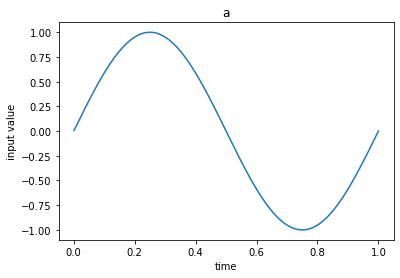

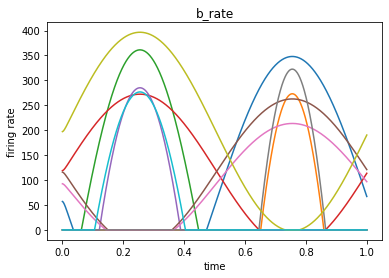

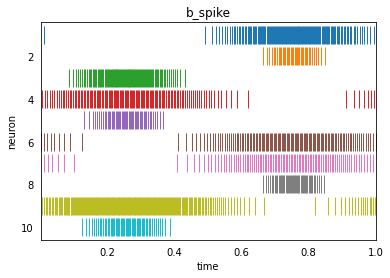

In [ ]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    # a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    a = nengo.Node(0)

    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)

    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)

    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)

with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000, data=np.sin(2*np.pi*np.arange(0, 1000)))

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")

plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike")
plt.show()

In [ ]:
# TODO: setup nengo-dl pipeline
# Start with ensembles, then add conv layers?
# Tensorboard

In [ ]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images
# train_images = train_images.reshape((train_images.shape[0], -1))
# test_images = test_images.reshape((test_images.shape[0], -1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [ ]:
print(test_images.shape, test_labels.shape)

(10000, 784) (10000,)


In [ ]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In [ ]:
print(train_images.shape, train_labels.shape)

(60000, 1, 784) (60000, 1, 1)


In [ ]:
print(test_images.shape, test_labels.shape)

(10000, 30, 784) (10000, 30, 1)
